## Use SORT tracking over a video collection and project results

Using a sort implementation originally by Alex Bewley, but adapted by [Chris Fotache](https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/README.md). For an example implementation, see [his notebook](https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/PyTorch_Object_Tracking.ipynb).



In [1]:
import cv2
from pathlib import Path
import numpy as np
from PIL import Image
import torch
from torchvision.io.video import read_video
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
import tempfile        

In [2]:
source = Path('../DATASETS/VIRAT_subset_0102x')
videos = list(source.glob('*.mp4'))
tmpdir = Path(tempfile.gettempdir()) / 'trajpred'
tmpdir.mkdir(exist_ok=True)


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Based on code from: https://stackabuse.com/retinanet-object-detection-with-pytorch-and-torchvision/

In [4]:
weights = RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT
model = retinanet_resnet50_fpn_v2(weights=weights, score_thresh=0.35)
model.to(device)
# Put the model in inference mode
model.eval()
# Get the transforms for the model's weights
preprocess = weights.transforms().to(device)

> The score_thresh argument defines the threshold at which an object is detected as an object of a class. Intuitively, it's the confidence threshold, and we won't classify an object to belong to a class if the model is less than 35% confident that it belongs to a class.

The result from a single prediction coming from `model(batch)` looks like:

```python
{'boxes': tensor([[5.7001e+02, 2.5786e+02, 6.3138e+02, 3.6970e+02],
         [5.0109e+02, 2.4508e+02, 5.5308e+02, 3.4852e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [5.0219e-01, 3.7588e+02, 9.7911e+01, 7.2000e+02],
         [3.4096e+02, 2.7015e+02, 3.6156e+02, 3.1857e+02],
         [8.3241e+01, 5.8410e+02, 1.7502e+02, 7.1743e+02]]),
 'scores': tensor([0.8525, 0.6491, 0.5985, 0.4999, 0.3753, 0.3746]),
 'labels': tensor([64, 64,  1, 64, 18, 86])}
```

In [5]:
%matplotlib inline


import pylab as pl
from IPython import display
from utils.timer import Timer
from sort_cfotache import Sort
import pickle


def track_video(video_path: Path) -> dict:
    tracked_instances = {}
    mot_tracker = Sort()

    video = cv2.VideoCapture(str(video_path))

    # timer = Timer()
    while True:
        # timer.tic()
        ret, frame = video.read()
        
        if not ret:
            # print("Can't receive frame (stream end?). Exiting ...")
            break

        t = torch.from_numpy(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        # change axes of image loaded image to be compatilbe with torch.io.read_image (which has C,W,H format instead of W,H,C)
        t = t.permute(2, 0, 1)

        batch = preprocess(t)[None, :].to(device)
        # no_grad can be used on inference, should be slightly faster
        with torch.no_grad():
            predictions = model(batch)
        prediction = predictions[0] # we feed only one frame at the once

        mask = prediction['labels'] == 1 # if we want more than one: np.isin(prediction['labels'], [1,86])

        scores = prediction['scores'][mask]
        labels = prediction['labels'][mask]
        boxes = prediction['boxes'][mask]
        
        # TODO: introduce confidence and NMS supression: https://github.com/cfotache/pytorch_objectdetecttrack/blob/master/PyTorch_Object_Tracking.ipynb
        # (which I _think_ we better do after filtering)
        # alternatively look at Soft-NMS https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c

        
        #  dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
        detections = np.array([np.append(bbox, [score, label]) for bbox, score, label in zip(boxes.cpu(), scores.cpu(), labels.cpu())])
        # print(detections)
        tracks = mot_tracker.update(detections)

        # now convert back to boxes and labels
        # print(tracks)
        boxes = np.array([t[:4] for t in tracks])
        # initialize empty with the necesserary dimensions for drawing_bounding_boxes glitch
        t_boxes = torch.from_numpy(boxes) if len(boxes) else torch.Tensor().new_empty([0, 6])
        labels = [str(int(t[4])) for t in tracks]
        # print(t_boxes, boxes, labels)



        for track in tracks:
            yield track
            

    #     print("time for frame: ", timer.toc(), ", avg:", 1/timer.average_time, "fps")

    #     display.clear_output(wait=True)

    # return tracked_instances

/home/ruben/suspicion/trajpred/sort_cfotache.py:36: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iou(bb_test,bb_gt):


In [6]:
def track_videos(video_paths: list[Path]) -> dict:
    # collect instances of all videos with unique key
    video_paths = list(video_paths)
    tracked_instances = {}
    timer = Timer()
    for i, p in enumerate(video_paths):
        print(f"{i}/{len(video_paths)}: {p}")

        cachefile = tmpdir / (p.name + '.pcl')
        if cachefile.exists():
            print('\tLoad pickle')
            with cachefile.open('rb') as fp:
             new_instances = pickle.load(fp)
        else:
            #continue # to quickly test from cache
            new_instances = {}
            timer.tic()
            for track in track_video(p):
                track_id = f"{i}_{str(int(track[4]))}"
                if track_id not in new_instances:
                    new_instances[track_id] = []
                new_instances[track_id].append(track)
            with cachefile.open('wb') as fp:
                pickle.dump(new_instances, fp)
            print(" time for video: ", timer.toc())
        tracked_instances.update(new_instances)
        
    return tracked_instances

In [7]:
tracked_instances = track_videos(videos)
len(tracked_instances)

0/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010200_00_000060_000218.mp4
	Load pickle
1/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010204_09_001285_001336.mp4
	Load pickle
2/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010203_08_000895_000975.mp4
	Load pickle
3/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010205_04_000545_000576.mp4
	Load pickle
4/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010207_04_000929_000954.mp4
	Load pickle
5/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010200_10_000923_000959.mp4
	Load pickle
6/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010205_06_000830_000904.mp4
	Load pickle
7/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010207_08_001308_001332.mp4
	Load pickle
8/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010207_09_001484_001510.mp4
	Load pickle
9/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010203_00_000047_000139.mp4
	Load pickle
10/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010205_03_000370_000395.mp4
	Load pickle
11/76: ../DATASETS/VIRAT_subset_0102x/VIRAT_S_010206_

5952

## Project / Homography

Now that all trajectories are captured (for a single video), these can then be projected onto a flat surface by [homography](https://en.wikipedia.org/wiki/Homography_(computer_vision)). The necessary $H$ matrix is already provided by VIRAT in the [homographies folder](https://data.kitware.com/#folder/56f581c88d777f753209c9d2) of their online data repository.

In [8]:

homography = list(source.glob('*img2world.txt'))[0]
H = np.loadtxt(homography, delimiter=',')



The homography matrix helps to transform points from image space to a flat world plane. The `README_homography.txt` from VIRAT describes:

> Roughly estimated 3-by-3 homographies are included for convenience. 
> Each homography H provides a mapping from image coordinate to scene-dependent world coordinate.
>   
> [xw,yw,zw]' = H*[xi,yi,1]'
> 
> xi: horizontal axis on image with left top corner as origin, increases right.
> yi: vertical axis on image with left top corner as origin, increases downward.
> 
> xw/zw: world x coordinate
> yw/zw: world y coordiante

(1200, 900)


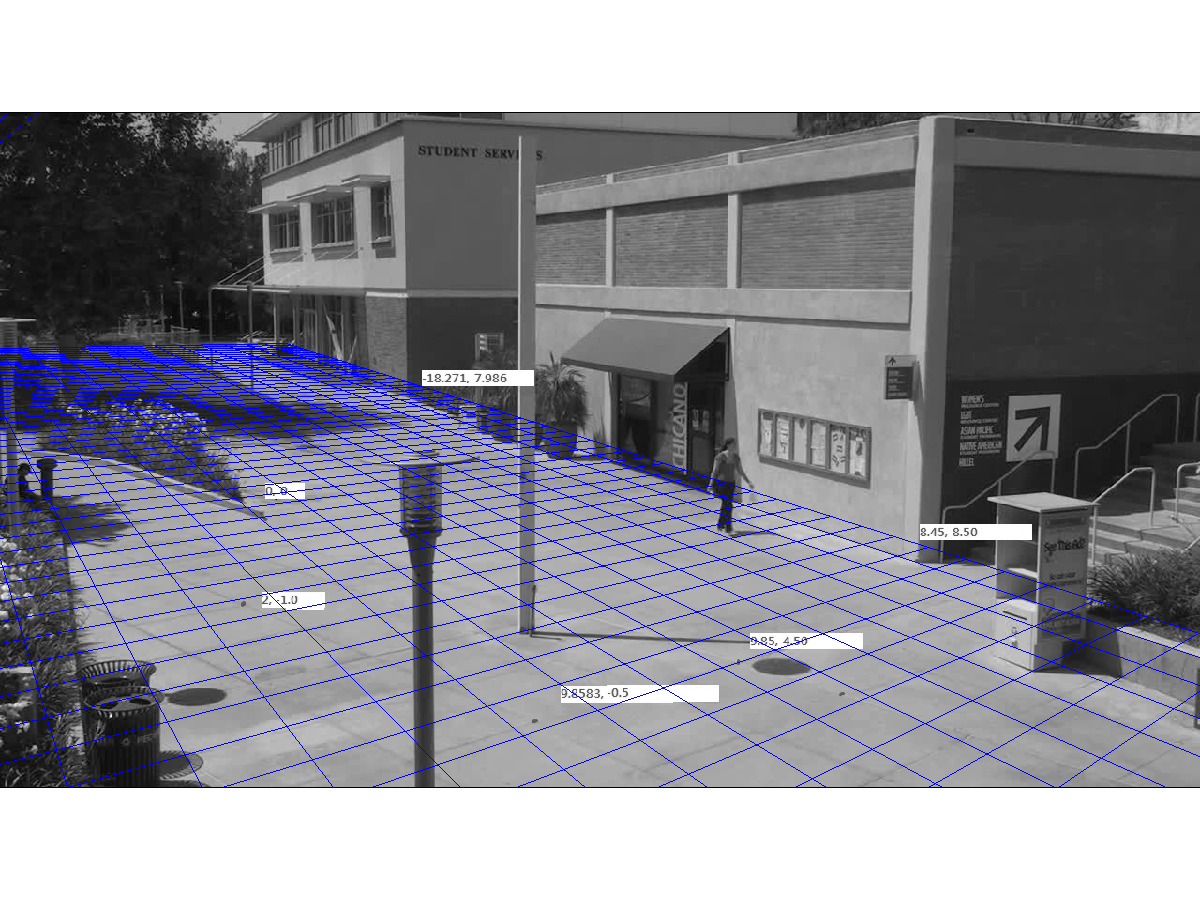

In [9]:
print(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_0102_homography_img2world.png").size)
Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_0102_homography_img2world.png")


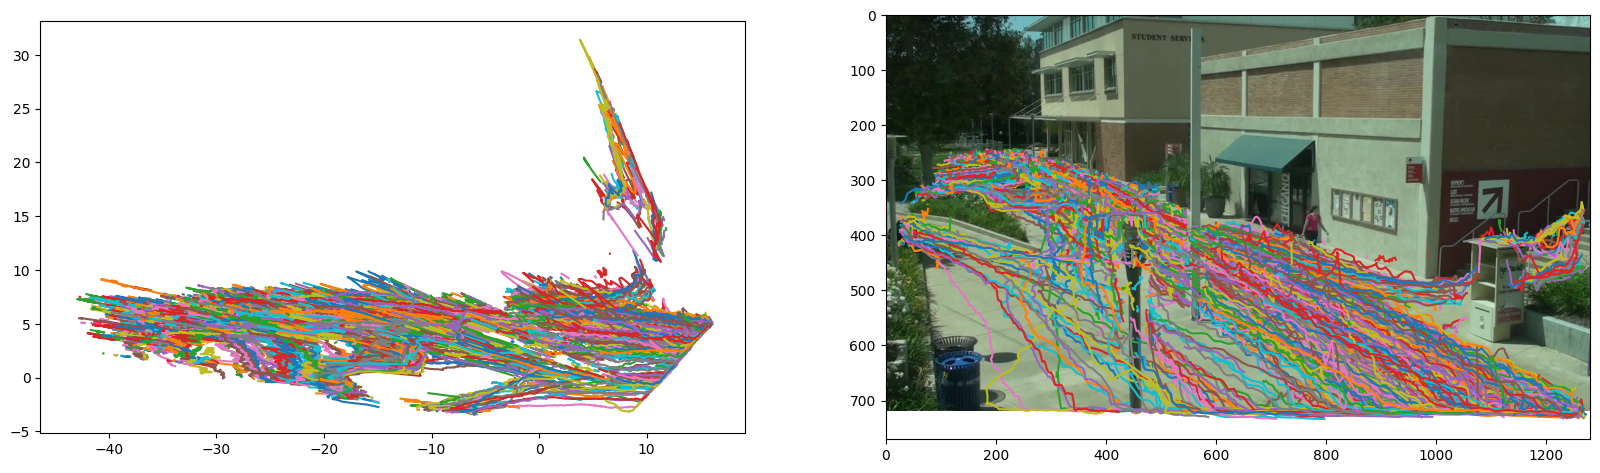

In [10]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(20,8))
ax1, ax2 = fig.subplots(1,2)

ax1.set_aspect(1)
ax2.imshow(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_S_0102.jpg"))

for track_id in tracked_instances:
    # print(track_id)
    bboxes = tracked_instances[track_id]
    traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]] for det in bboxes])
    projected_traj = cv2.perspectiveTransform(traj,H)
    # plt.plot(projected_traj[:,0])
    ax1.plot(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1))
    ax2.plot(traj[:,:,0].reshape(-1), traj[:,:,1].reshape(-1))
    
plt.show()

What if the projection is a heatmap of where people are (tracking would not really be necessary for this thoug). Using the above plot and some blurring effects of pyplot from [their documentation](https://matplotlib.org/stable/gallery/misc/demo_agg_filter.html)

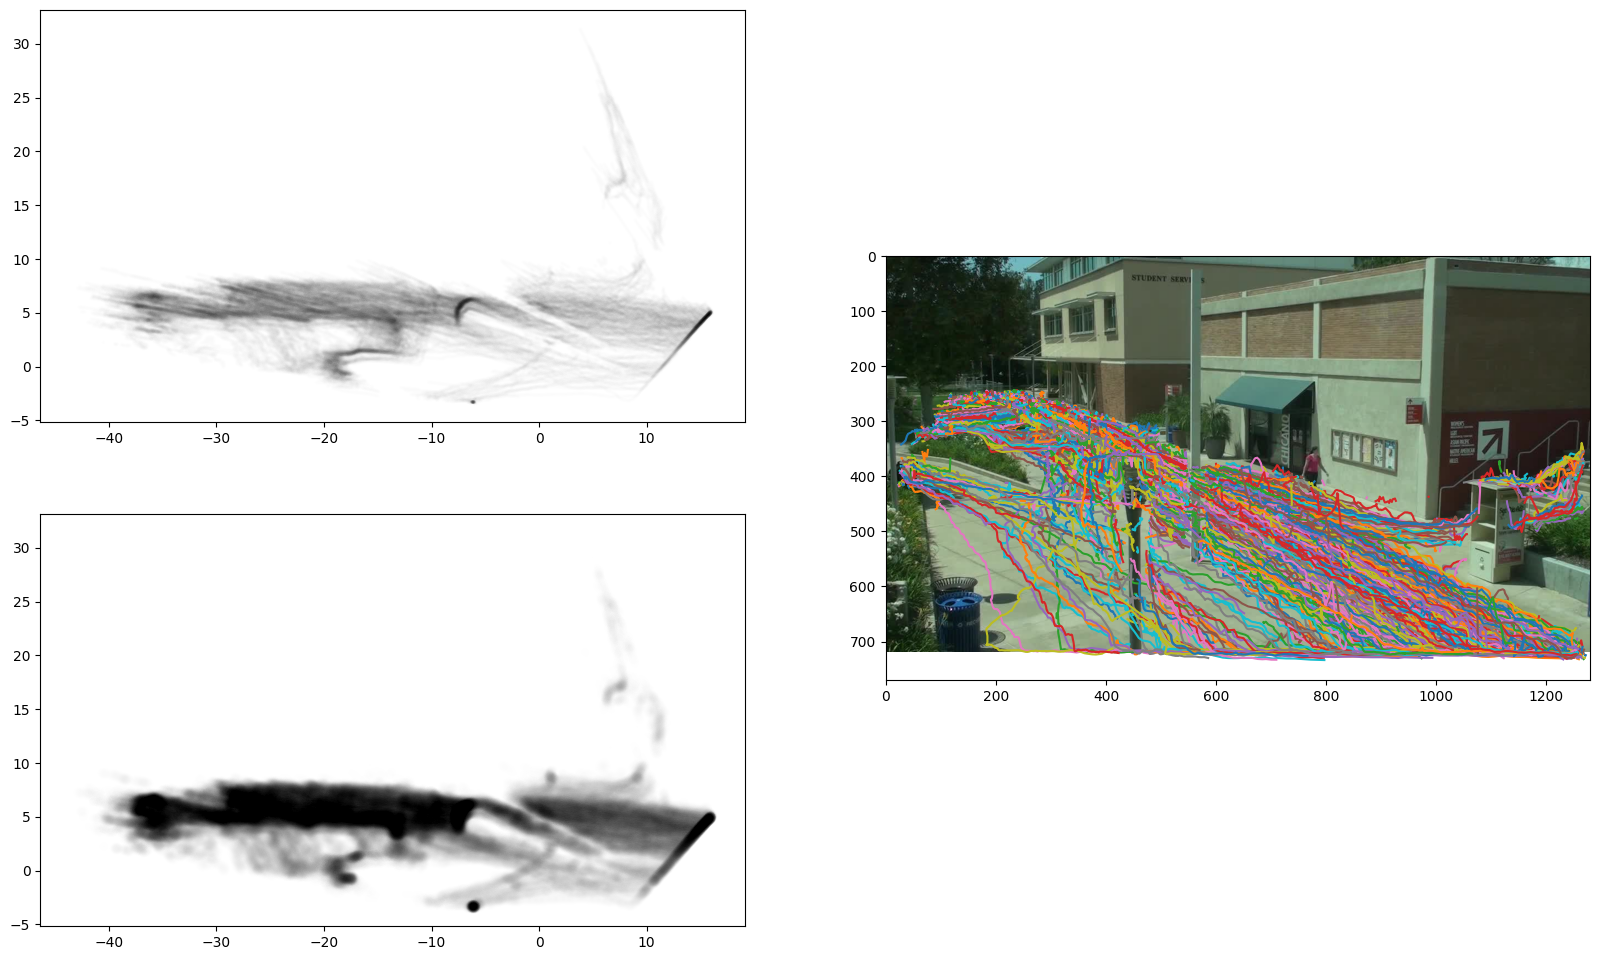

In [37]:
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib.transforms as mtransforms
from matplotlib.colors import LightSource
from matplotlib.artist import Artist


def smooth1d(x, window_len):
    # copied from https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    s = np.r_[2*x[0] - x[window_len:1:-1], x, 2*x[-1] - x[-1:-window_len:-1]]
    w = np.hanning(window_len)
    y = np.convolve(w/w.sum(), s, mode='same')
    return y[window_len-1:-window_len+1]


def smooth2d(A, sigma=3):
    window_len = max(int(sigma), 3) * 2 + 1
    A = np.apply_along_axis(smooth1d, 0, A, window_len)
    A = np.apply_along_axis(smooth1d, 1, A, window_len)
    return A


class BaseFilter:

    def get_pad(self, dpi):
        return 0

    def process_image(self, padded_src, dpi):
        raise NotImplementedError("Should be overridden by subclasses")

    def __call__(self, im, dpi):
        pad = self.get_pad(dpi)
        padded_src = np.pad(im, [(pad, pad), (pad, pad), (0, 0)], "constant")
        tgt_image = self.process_image(padded_src, dpi)
        return tgt_image, -pad, -pad



class GaussianFilter(BaseFilter):
    """Simple Gaussian filter."""

    def __init__(self, sigma, alpha=0.5, color=(0, 0, 0)):
        self.sigma = sigma
        self.alpha = alpha
        self.color = color

    def get_pad(self, dpi):
        return int(self.sigma*3 / 72 * dpi)

    def process_image(self, padded_src, dpi):
        tgt_image = np.empty_like(padded_src)
        tgt_image[:, :, :3] = self.color
        tgt_image[:, :, 3] = smooth2d(padded_src[:, :, 3] * self.alpha,
                                      self.sigma / 72 * dpi)
        return tgt_image

gauss = GaussianFilter(2)

fig = plt.figure(figsize=(20,12))


# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

# (ax1, ax2), (ax3, ax4) = fig.subplots(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[:,1])

ax1.set_aspect(1)
ax3.set_aspect(1)

ax2.imshow(Image.open("../DATASETS/VIRAT_subset_0102x/VIRAT_S_0102.jpg"))

for track_id in tracked_instances:
    # print(track_id)
    bboxes = tracked_instances[track_id]
    traj = np.array([[[0.5 * (det[0]+det[2]), det[3]]] for det in bboxes])
    projected_traj = cv2.perspectiveTransform(traj,H)
    # plt.plot(projected_traj[:,0])
    line, = ax1.plot(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1), color=(0,0,0,0.05))
    line.set_agg_filter(gauss)
    line.set_rasterized(True) # "to suport mixed-mode renderers"

    points = ax3.scatter(projected_traj[:,:,0].reshape(-1), projected_traj[:,:,1].reshape(-1), color=(0,0,0,0.01))
    points.set_agg_filter(gauss)
    points.set_rasterized(True) # "to suport mixed-mode renderers"

    ax2.plot(traj[:,:,0].reshape(-1), traj[:,:,1].reshape(-1))
    
plt.show()